# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR to simulate the challenges Scones Unlimited are facing in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL!

### 1. Extract the data from the hosting service

In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [1]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    # Todo: request the data from the data url
    # Hint: use `requests.get` method
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

Let's test it out! Run the following cell and check whether a new file `cifar.tar.gz` is created in the file explorer.

In [2]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress your extracted dataset:

In [3]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below for you to run:

In [4]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [5]:
32*32*3

3072

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [6]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version, consider the following:

In [7]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

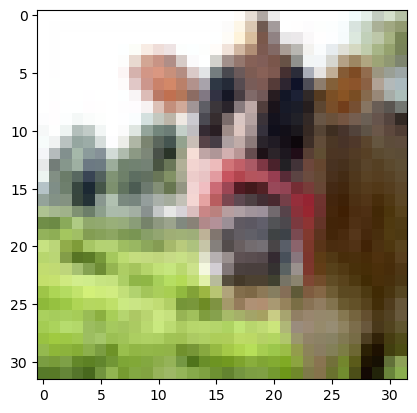

In [8]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [9]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [10]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [11]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now we know how to check labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [12]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [13]:
plt.imsave("file.png", test_image)

Your new PNG file should now appear in the file explorer -- go ahead and pop it open to see!

Now that you know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [14]:
import pandas as pd

# Extract the labels for the bicycles and motorcycles
label_name_id_df = pd.DataFrame(dataset_train[b'fine_labels'], columns=["label_name_id"])
labels_df = pd.DataFrame([x.decode('utf-8') for x in dataset_meta[b'fine_label_names']], columns=['label'])

# Merge the labels with the label names
full_label_df = label_name_id_df.merge(labels_df, left_on='label_name_id', right_index=True)

# Filter the labels for bicycles and motorcycles
filtered_label_df = full_label_df[full_label_df['label'].isin(['bicycle', 'motorcycle'])]

# Get the indexes of the filtered labels
target_indexes = filtered_label_df.index.to_list()

In [15]:
# Determining how many images are in the dataset
filtered_label_df['label_name_id'].value_counts()

label_name_id
8     500
48    500
Name: count, dtype: int64

[ 35  27  31 ... 150 132 118]


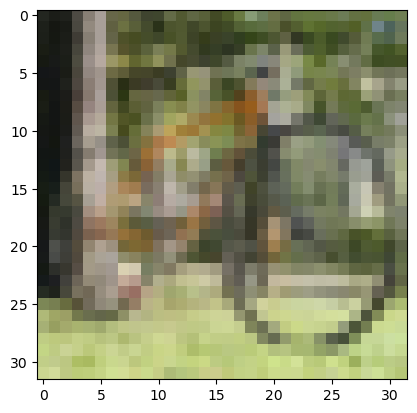

In [16]:
import pandas as pd

def get_rbg(row):
    test_image = np.dstack((
        row[0:1024].reshape(32,32),
        row[1024:2048].reshape(32,32),
        row[2048:].reshape(32,32)
    ))
    return test_image

# Todo: Filter the dataset_train and dataset_meta objects to find the label numbers for Bicycle and Motorcycles
for row in dataset_train[b'data'][target_indexes]:
    print(row)
    test_image = get_rbg(row)
    plt.imshow(test_image);
    break

Good job! We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we construct a dataframe for you, and you can safely drop the rows that don't contain observations about bicycles and motorcycles. Fill in the missing lines below to drop all other rows:

In [17]:
# Extracting labels
fine_label_df = pd.DataFrame([label.decode('utf-8') for label in dataset_meta[b'fine_label_names']], columns=["fine_label"])
coarse_label_df = pd.DataFrame([label.decode('utf-8') for label in dataset_meta[b'coarse_label_names']], columns=["coarse_label"])

#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "coarse_labels": dataset_train[b'coarse_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)

# Join the labels
df_train = df_train.merge(fine_label_df, left_on="labels", right_index=True)
df_train = df_train.merge(coarse_label_df, left_on="coarse_labels", right_index=True)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "coarse_labels": dataset_test[b'coarse_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Join the labels
df_test = df_test.merge(fine_label_df, left_on="labels", right_index=True)
df_test = df_test.merge(coarse_label_df, left_on="coarse_labels", right_index=True)

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)


# Filter data for training
df_train = df_train[df_train["coarse_label"].str.contains("vehicles_1")]
df_test = df_test[df_test["coarse_label"].str.contains("vehicles_1")]

# Turning labels into sequences
df_train = (
    df_train
    .rename(columns={"labels": "original_labels"})
    .assign(labels=df_train['labels'].transform("rank", method="dense").astype(int)-1)
)

df_test = (
    df_test
    .rename(columns={"labels": "original_labels"})
    .assign(labels=df_test['labels'].transform("rank", method="dense").astype(int)-1)
)

In [18]:
df_test.head()

,filenames,original_labels,coarse_labels,row,fine_label,coarse_label,labels
27,safety_bike_s_000390.png,8,18,27,bicycle,vehicles_1,0
28,bike_s_000658.png,8,18,28,bicycle,vehicles_1,0
36,pickup_truck_s_002755.png,58,18,36,pickup_truck,vehicles_1,3
47,pickup_s_000322.png,58,18,47,pickup_truck,vehicles_1,3
71,freight_train_s_000009.png,90,18,71,train,vehicles_1,4


Now that the data is filtered for just our classes, we can save all our images.

In [19]:
df_train["fine_label"].value_counts()

fine_label
train           500
bicycle         500
motorcycle      500
bus             500
pickup_truck    500
Name: count, dtype: int64

In [20]:
df_train.head()

,filenames,original_labels,coarse_labels,row,fine_label,coarse_label,labels
6,car_train_s_000043.png,90,18,6,train,vehicles_1,4
16,bike_s_000682.png,8,18,16,bicycle,vehicles_1,0
30,bike_s_000127.png,8,18,30,bicycle,vehicles_1,0
47,train_s_001640.png,90,18,47,train,vehicles_1,4
130,cycle_s_002598.png,8,18,130,bicycle,vehicles_1,0


In [21]:
!rm -r ./train
!rm -r ./test
!mkdir ./train
!mkdir ./test

In the previous sections we introduced you to several key snippets of code:

1. Grabbing the image data:

```python
dataset_train[b'data'][0]
```

2. A simple idiom for stacking the image data into the right shape

```python
import numpy as np
np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))
```

3. A simple `matplotlib` utility for saving images

```python
plt.imsave(path+row['filenames'], target)
```

Compose these together into a function that saves all the images into the `./test` and `./train` directories. Use the comments in the body of the `save_images` function below to guide your construction of the function:


In [22]:
def save_images():
    
    for index, row in df_train.iterrows():
        plt.imsave(f"./train/{row['filenames']}", get_rbg(dataset_train[b'data'][row['row']]))

    for index, row in df_test.iterrows():
        plt.imsave(f"./test/{row['filenames']}", get_rbg(dataset_test[b'data'][row['row']]))
    
    # Return any signal data you want for debugging
    return 0

save_images()

0

### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

In [23]:
import sagemaker

bucket= "udacity-landingzone"
print("Default Bucket: {}".format(bucket))

region = "us-east-1"
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Default Bucket: udacity-landingzone
AWS Region: us-east-1
RoleArn: arn:aws:iam::002427974286:role/service-role/AmazonSageMaker-ExecutionRole-20240924T190146


With this data we can easily sync your data up into S3!

In [24]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/projects/ml-workflow/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/projects/ml-workflow/test/

upload: train/bicycle_s_000017.png to s3://udacity-landingzone/projects/ml-workflow/train/bicycle_s_000017.png
upload: train/bicycle_s_000038.png to s3://udacity-landingzone/projects/ml-workflow/train/bicycle_s_000038.png
upload: train/bicycle_s_000035.png to s3://udacity-landingzone/projects/ml-workflow/train/bicycle_s_000035.png
upload: train/bicycle_s_000066.png to s3://udacity-landingzone/projects/ml-workflow/train/bicycle_s_000066.png
upload: train/bicycle_s_000051.png to s3://udacity-landingzone/projects/ml-workflow/train/bicycle_s_000051.png
upload: train/bicycle_s_000043.png to s3://udacity-landingzone/projects/ml-workflow/train/bicycle_s_000043.png
upload: train/bicycle_s_000021.png to s3://udacity-landingzone/projects/ml-workflow/train/bicycle_s_000021.png
upload: train/bicycle_s_000156.png to s3://udacity-landingzone/projects/ml-workflow/train/bicycle_s_000156.png
upload: train/bicycle_s_000039.png to s3://udacity-landingzone/projects/ml-workflow/train/bicycle_s_000039.png
u

And that's it! You can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

### Setting up for model Training


In [25]:
import boto3
# Saving labels to fetch in workload to create categories
def save_category_file(bucket: str, df: pd.DataFrame) -> int:
    """
    A function to save the category file to S3 to use in the workload

    Parameters:
    bucket -- the bucket to save the file to
    df -- the dataframe containing the labels and categories
    """

    # Creating label mapping file
    label_categories_df = df_train[["fine_label", "labels"]].drop_duplicates()
    label_categories_df = label_categories_df.set_index("labels").sort_index()

    # Creating temp folder if no exists
    if not os.path.exists("./temp"):
        os.makedirs("./temp")


    # Saving label mapping file to temp
    label_categories_df = label_categories_df.rename(columns={"fine_label": "key_mapping"})
    label_categories_df.to_json("./temp/label_categories.json")
    print("-> Showing labels to train")
    display(label_categories_df)


    # Uploading label mapping file to S3
    print("-> Uploading label mapping file to S3")
    s3_client = boto3.client('s3')
    s3_client.upload_file("./temp/label_categories.json", bucket, "projects/ml-workflow/landingzone/label_categories.json")

    return 0

save_category_file(bucket, df_train)

-> Showing labels to train


,key_mapping
labels,
0,bicycle
1,bus
2,motorcycle
3,pickup_truck
4,train


-> Uploading label mapping file to S3


0

In [26]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [27]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('projects/ml-workflow/train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('projects/ml-workflow/test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [28]:
# Testing upload of mapping
# Readd category mapping file from S3
import json
s3 = boto3.client('s3')
response = s3.get_object(Bucket=bucket, Key="projects/ml-workflow/landingzone/label_categories.json")
category_mapping = json.loads(response['Body'].read().decode('utf-8'))

category_mapping['key_mapping'].get(str(0)), category_mapping['key_mapping'].get(str(1))

('bicycle', 'bus')

In [29]:
# num_classes for hyperparameters for training
num_classes = len(category_mapping['key_mapping'])

In [30]:
# Use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = sagemaker.image_uris.retrieve("image-classification", region)
s3_output_location = f"s3://{bucket}/projects/ml-workflow/models/image_model"

We're ready to create an estimator! Create an estimator `img_classifier_model` that uses one instance of `ml.p3.2xlarge`. Ensure that y ou use the output location we defined above - we'll be referring to that later!

In [31]:
img_classifier_model=sagemaker.estimator.Estimator(
    image_uri=algo_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    volume_size=50,
    max_run=3600,
    input_mode='File',
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session()
)

We can also set a few key hyperparameters and define the inputs for our model:

In [32]:
img_classifier_model.set_hyperparameters(
    image_shape="3,32,32",
    num_classes=num_classes,
    num_training_samples=len(df_train),
    weight_decay=0.0001,
    learning_rate=0.001,
    lr_scheduler_step=5,
    lr_scheduler_factor=0.1,
    num_layers=18, #tried 38 and 50, best on 18
    early_stopping=1, # best on
    early_stopping_patience=5, # best on
    augmentation_type='crop_color' # best on
)

The `image-classification` image uses four input channels with very specific input parameters. For convenience, we've provided them below:

In [33]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/projects/ml-workflow/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/projects/ml-workflow/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/projects/ml-workflow/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/projects/ml-workflow/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs. In the cell below, call the `fit` method on our model,:

In [34]:
## TODO: train your model
# img_classifier_model.fit(inputs=model_inputs, logs=True)

In [ ]:
from sagemaker.tuner import ContinuousParameter, IntegerParameter, CategoricalParameter, HyperparameterTuner

# Define hyperparameter ranges with additional parameters
hyperparameter_ranges = {
    'learning_rate': ContinuousParameter(0.001, 0.05),
    'weight_decay': ContinuousParameter(0.00001, 0.01),
    'mini_batch_size': IntegerParameter(8, 128),
    'momentum': ContinuousParameter(0.6, 0.99)
}


# Set up the hyperparameter tuner
tuner = HyperparameterTuner(
    estimator=img_classifier_model,
    hyperparameter_ranges=hyperparameter_ranges,
    objective_metric_name='validation:accuracy',
    max_jobs=10, # tried 20 and 30, best on 10 with right hyperparameters. Faster training better results
    max_parallel_jobs=1
)

# Start tuning
tuner.fit(inputs=model_inputs, logs=True)

# Wait for the tuning job to complete
tuner.wait()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


............................................................................................................................................................................................!
!


In [36]:
from sagemaker.tuner import HyperparameterTuningJobAnalytics
from sagemaker.estimator import Estimator

# Analyze the hyperparameter tuning job results
tuning_job_name = tuner.latest_tuning_job.name

# Create an analytics object to analyze the results
tuning_job_analytics = HyperparameterTuningJobAnalytics(tuning_job_name)

# Get the best training job based on the objective metric
best_training_job = tuning_job_analytics.dataframe().sort_values(
    by='FinalObjectiveValue', ascending=False
).iloc[0]

# Get the name of the best training job
best_training_job_name = best_training_job['TrainingJobName']

print(f"Best training job: {best_training_job_name}")

# Get the best model's score
best_score = best_training_job['FinalObjectiveValue']

print(f"Best model score (validation accuracy): {best_score}")

# Best estimator to deploy
best_estimator = Estimator.attach(best_training_job_name)

Best training job: image-classification-241028-1357-004-e44fe5da
Best model score (validation accuracy): 0.8245970010757446

2024-10-28 14:12:06 Starting - Found matching resource for reuse
2024-10-28 14:12:06 Downloading - Downloading the training image
2024-10-28 14:12:06 Training - Training image download completed. Training in progress.
2024-10-28 14:12:06 Uploading - Uploading generated training model
2024-10-28 14:12:06 Completed - Resource reused by training job: image-classification-241028-1357-005-6d4b7c9b


If all goes well, you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [37]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/projects/ml-workflow/data_capture"
)

Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, deploy your model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [38]:
endpoint_name = "scones-unlimited-prod-ep"
# Create endpoint
try:
    sagemaker_client = boto3.client('sagemaker')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
except: pass
deployment = best_estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    data_capture_config=data_capture_config,
    endpoint_name=endpoint_name
    )

endpoint = deployment.endpoint_name
print(endpoint)

--------------!scones-unlimited-prod-ep


Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [39]:
predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint)

In the code snippet below we are going to prepare one of your saved images for prediction. Use the predictor to process the `payload`.

In [40]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_000513.png", "rb") as f:
    payload = f.read()

    
inference = predictor.predict(payload)

Your `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

In [41]:
print(inference)

b'[0.8031924962997437, 0.02847396582365036, 0.16176168620586395, 0.003500311868265271, 0.0030715561006218195]'


In [42]:
# Delete the deployed endpoint, the endpoint will be re-started in the 
# Scones Unlimited Data Ingestion Workload Invocation section of this notebook
deployment.delete_endpoint()

print(f"Endpoint '{endpoint_name}' deleted.")


Endpoint 'scones-unlimited-prod-ep' deleted.


### Registering New Model Version

In [43]:
# Get the model artifact URI from the best estimator
model_artifact = best_estimator.model_data
print(f"Best model artifact URI: {model_artifact}")

Best model artifact URI: s3://udacity-landingzone/projects/ml-workflow/models/image_model/image-classification-241028-1357-004-e44fe5da/output/model.tar.gz


In [45]:
import boto3

# Initialize the SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Define the model package group name
model_package_group_name = 'Model-Group-1729986112524'

# Create a new model package group (if it doesn't exist)
try:
    sagemaker_client.create_model_package_group(
        ModelPackageGroupName=model_package_group_name,
        ModelPackageGroupDescription='Model group for managing scones-unlimited model versions'
    )
    print(f"Created Model Package Group: {model_package_group_name}")
except:
    print(f"Model Package Group {model_package_group_name} already exists.")


Model Package Group Model-Group-1729986112524 already exists.


In [46]:
from sagemaker import ModelPackage

# Define the model package input parameters
model_package_input = {
    'ModelPackageGroupName': model_package_group_name,
    'ModelPackageDescription': f'New version of the model with score {best_score}',
    'InferenceSpecification': {
        'Containers': [
            {
                'Image': img_classifier_model.image_uri,  # Model image URI
                'ModelDataUrl': model_artifact  # Best model artifact URI
            }
        ],
        'SupportedContentTypes': ['application/x-image'],
        'SupportedResponseMIMETypes': ['application/json'],
        'SupportedRealtimeInferenceInstanceTypes': ['ml.m5.large'],
    },
    'ModelApprovalStatus': 'Approved'
}

# Register the model package
response = sagemaker_client.create_model_package(**model_package_input)
model_package_arn = response['ModelPackageArn']

print(f"Registered new model version with ARN: {model_package_arn}")


Registered new model version with ARN: arn:aws:sagemaker:us-east-1:002427974286:model-package/Model-Group-1729986112524/3


> Notes: This model group will be the one used for the lambda integrations. Since I am not completing the project in one shot, it is best to register a model group and deploy from there once I am ready to work with the best model again.

### Draft Lambdas and Step Function Workflow

Your operations team uses Step Functions to orchestrate serverless workflows. One of the nice things about Step Functions is that [workflows can call other workflows](https://docs.aws.amazon.com/step-functions/latest/dg/connect-stepfunctions.html), so the team can easily plug your workflow into the broader production architecture for Scones Unlimited.

In this next stage you're going to write and deploy three Lambda functions, and then use the Step Functions visual editor to chain them together! Our functions are going to work with a simple data object:

```python
{
    "inferences": [], # Output of predictor.predict
    "s3_key": "", # Source data S3 key
    "s3_bucket": "", # Source data S3 bucket
    "image_data": ""  # base64 encoded string containing the image data
}
```

A good test object that you can use for Lambda tests and Step Function executions, throughout the next section, might look like this:

```python
{
  "image_data": "",
  "s3_bucket": MY_BUCKET_NAME, # Fill in with your bucket
  "s3_key": "test/bicycle_s_000513.png"
}
```

Using these fields, your functions can read and write the necessary data to execute your workflow. Let's start with the first function. Your first Lambda function will copy an object from S3, base64 encode it, and then return it to the step function as `image_data` in an event.

Go to the Lambda dashboard and create a new Lambda function with a descriptive name like "serializeImageData" and select thr 'Python 3.8' runtime. Add the same permissions as the SageMaker role you created earlier. (Reminder: you do this in the Configuration tab under "Permissions"). Once you're ready, use the starter code below to craft your Lambda handler:

```python
import json
import boto3
import base64

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""
    
    # Get the s3 address from the Step Function event input
    key = ## TODO: fill in
    bucket = ## TODO: fill in
    
    # Download the data from s3 to /tmp/image.png
    ## TODO: fill in
    
    # We read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    # Pass the data back to the Step Function
    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }
```

The next function is responsible for the classification part - we're going to take the image output from the previous function, decode it, and then pass inferences back to the the Step Function.

Because this Lambda will have runtime dependencies (i.e. the SageMaker SDK) you'll need to package them in your function. *Key reading:* https://docs.aws.amazon.com/lambda/latest/dg/python-package-create.html#python-package-create-with-dependency

Create a new Lambda function with the same rights and a descriptive name, then fill in the starter code below for your classifier Lambda.

```python
import json
import sagemaker
import base64
from sagemaker.serializers import IdentitySerializer

# Fill this in with the name of your deployed model
ENDPOINT = ## TODO: fill in

def lambda_handler(event, context):

    # Decode the image data
    image = base64.b64decode(## TODO: fill in)

    # Instantiate a Predictor
    predictor = ## TODO: fill in

    # For this model the IdentitySerializer needs to be "image/png"
    predictor.serializer = IdentitySerializer("image/png")
    
    # Make a prediction:
    inferences = ## TODO: fill in
    
    # We return the data back to the Step Function    
    event["inferences"] = inferences.decode('utf-8')
    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```

Finally, we need to filter low-confidence inferences. Define a threshold between 1.00 and 0.000 for your model: what is reasonble for you? If the model predicts at `.70` for it's highest confidence label, do we want to pass that inference along to downstream systems? Make one last Lambda function and tee up the same permissions:

```python
import json


THRESHOLD = .93


def lambda_handler(event, context):
    
    # Grab the inferences from the event
    inferences = ## TODO: fill in
    
    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = ## TODO: fill in
    
    # If our threshold is met, pass our data back out of the
    # Step Function, else, end the Step Function with an error
    if meets_threshold:
        pass
    else:
        raise("THRESHOLD_CONFIDENCE_NOT_MET")

    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```
Once you have tested the lambda functions, save the code for each lambda function in a python script called 'lambda.py'.

With your lambdas in place, you can use the Step Functions visual editor to construct a workflow that chains them together. In the Step Functions console you'll have the option to author a Standard step function *Visually*.

When the visual editor opens, you'll have many options to add transitions in your workflow. We're going to keep it simple and have just one: to invoke Lambda functions. Add three of them chained together. For each one, you'll be able to select the Lambda functions you just created in the proper order, filter inputs and outputs, and give them descriptive names.

Make sure that you:

1. Are properly filtering the inputs and outputs of your invokations (e.g. `$.body`)
2. Take care to remove the error handling from the last function - it's supposed to "fail loudly" for your operations colleagues!

Take a screenshot of your working step function in action and export the step function as JSON for your submission package.

### Saved lambdas

In [ ]:
%%writefile lambda.py

###############################################
# Setp 1: invokeSconesUnlimitedImageCategorizer
# This lambda function is triggered by an S3 event and starts the Step Function

import json
import random
import boto3

def lambda_handler(event, context):

    bucket = event["Records"][0]["s3"]["bucket"]["name"]
    s3_key = event["Records"][0]["s3"]["object"]["key"]
    print(f"-> Processing key: {s3_key}")

    print("-> Setting up payload...")
    json_payload = json.dumps({
            "s3_bucket": bucket,
            "s3_key": event["Records"][0]["s3"]["object"]["key"]
        })

    # Initialize the Step Functions client
    sfn_client = boto3.client('stepfunctions')
    step_function_arn = 'arn:aws:states:us-east-1:002427974286:stateMachine:scones-unlimited-state-machine'


    # Start Step Function execution
    try:
        print("-> Invoking scones step function...")
        response = sfn_client.start_execution(
            stateMachineArn=step_function_arn,
            input=json_payload
        )
        
        # Print execution details
        execution_arn = response['executionArn']
        print(f"Step Function invoked successfully! Execution ARN: {execution_arn}")

        return {
            'statusCode': 200,
            'body': json.dumps('Step Function Started!')
        }

    except:
        return {
            'statusCode': 500,
            'body': 'Failed to run scones unlimited state machine!'
        }

############################
# Setp 2: serializeImageData
# This lambda function is triggered by the Step Function and serializes the image data

import json
import boto3
import base64

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""
    
    # Get the s3 address from the Step Function event input
    key = event["s3_key"]
    bucket = event["s3_bucket"]
    
    # Download the data from s3 to /tmp/image.png
    s3.download_file(bucket, key, "/tmp/image.png")
    
    # We read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    # Pass the data back to the Step Function
    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }

#########################
# Setp 3: imageClassifier
# This lambda function is triggered by the Step Function and classifies the image

import json
import boto3
import base64

# Fill this in with the name of your deployed model
ENDPOINT = "scones-unlimited-prod-ep"
REGION = "us-east-1"

def lambda_handler(event, context):

    # Decode the image data
    image = base64.b64decode(event["body"]["image_data"])

    # Create a boto3 client for runtime SageMaker
    sagemaker_runtime = boto3.client('sagemaker-runtime', region_name=REGION)

    # Make a prediction call using boto3
    response = sagemaker_runtime.invoke_endpoint(
        EndpointName=ENDPOINT,
        ContentType='image/png',
        Body=image
    )

    # Get the inference result from the response
    inferences = response['Body'].read()

    # We return the data back to the Step Function    
    return {
        'statusCode': 200,
        'body': {
            'inferences': inferences.decode('utf-8'),
            's3_bucket': event["body"]["s3_bucket"],
            's3_key': event["body"]["s3_key"],
        }
    }


#############################
# Step 4: lowConfidenceFilter
# This lambda function is triggered by the Step Function and filters out low confidence inferences
# I would turn this into a Lambda function that set the categories. E.g. (bicycle, motorcycle, unlabeled)
# But to keep the integrity of the project lambdas, I will categorize in the later step.

import json


THRESHOLD = .94


def lambda_handler(event, context):
    
    # Grab the inferences from the event
    body = event["body"]
    inferences = json.loads(body["inferences"])
    
    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = any([float(x) >= THRESHOLD for x in inferences])
    
    # If our threshold is met, pass our data back out of the
    # Step Function, else, end the Step Function with an error
    if meets_threshold:
        pass
    else:
        raise("THRESHOLD_CONFIDENCE_NOT_MET")

    return {
        'statusCode': 200,
        'body': {
            'inferences': inferences,
            's3_bucket': event["body"]["s3_bucket"],
            's3_key': event["body"]["s3_key"],
        }
        
    }

########################
# Step 5: moveToDatalake
# This lambda function is triggered by the Step Function and moves the data to the datalake
# into the appropriate category key

import boto3
import json

def lambda_handler(event, context):

    # Get the s3 address from the Step Function event input
    print("Event:", event)
    body = event["body"]
    bucket = body["s3_bucket"]
    source_s3_key = body["s3_key"]
    inferences = body["inferences"]

    # Readd category mapping file from S3
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket, Key="projects/ml-workflow/landingzone/label_categories.json")
    category_mapping = json.loads(response['Body'].read().decode('utf-8'))

    def set_inference_label():
        # Find which index has the highest value
        max_inference_value = max(inferences)
        max_index = inferences.index(max_inference_value)

        return category_mapping["key_mapping"][str(max_index)]
    
    key_category = set_inference_label()

    try:

        # Copy the data from the raw bucket to the processed bucket
        copy_source = {
            'Bucket': bucket,
            'Key': source_s3_key
        }
        
        # Get file name from the source_s3_key
        file_name = source_s3_key.split("/")[-1]
        destination_key = f"projects/ml-workflow/landingzone/categorized_data/{key_category}/{file_name}"
        print(f"Copying {source_s3_key} to {destination_key}.")
        s3.copy(copy_source, bucket, destination_key)
        
        # Delete the data from the raw bucket
        print(f"Deleting {source_s3_key} from raw bucket...")
        s3.delete_object(Bucket=bucket, Key=source_s3_key)
        
        # Move any other file in the source folder to the processed folder
        print(f"Moving any other files in the source folder to the processed folder...")
        
    except Exception as e:
        raise Exception(f"Error moving data to datalake: {e}")

    # Move all objects to the processed folder to unknown category
    try:
        # Extract folder key from the source_s3_key
        folder_key = "/".join(source_s3_key.split("/")[:-1]) + "/"
        print("-> Folder Key:", folder_key)
        
        # List all objects in the source folder
        response = s3.list_objects_v2(Bucket=bucket, Prefix=folder_key)
        
        # Move all objects to the processed folder to unknown category
        contents = response.get("Contents", None)
        if contents:
            for obj in contents:
                if obj["Key"] != source_s3_key:
                    file_name = obj["Key"].split("/")[-1]
                    destination_key = f"projects/ml-workflow/landingzone/categorized_data/unknown/{file_name}"
                    print(f"Copying {obj['Key']} to datalake s3://{bucket}{destination_key}...")
                    copy_source = {
                        'Bucket': bucket,
                        'Key': obj["Key"]
                    }
                    s3.copy(copy_source, bucket, destination_key)
                    print(f"Deleting {obj['Key']} from raw bucket...")
                    s3.delete_object(Bucket=bucket, Key=obj["Key"])
        else:
            print("-> Nothing to move to unknown for relabeling.")
                
    except Exception as e:
        raise Exception(f"Error moving data to datalake: {e}")
    
    return {
        'statusCode': 200,
        'body': json.dumps('Data moved to datalake!')
    }


Great! Now you can use the files in `./test` as test files for our workflow. Depending on our threshold, our workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

Do several step function invokations using data from the `./test` folder. This process should give you confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of your data and inferences which we can visualize.

Here's a function that can help you generate test inputs for your invokations:

In [ ]:
import random
import boto3
import json

def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix="projects/ml-workflow/test")
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })
    
json_payload = generate_test_case()

# Initialize the Step Functions client
sfn_client = boto3.client('stepfunctions')
step_function_arn = 'arn:aws:states:us-east-1:002427974286:stateMachine:scones-unlimited-state-machine'


# Start Step Function execution
try:
    response = sfn_client.start_execution(
        stateMachineArn=step_function_arn,
        input=json_payload
    )
    
    # Print execution details
    execution_arn = response['executionArn']
    print(f"Step Function invoked successfully! Execution ARN: {execution_arn}")
    
except sfn_client.exceptions.InvalidArn as e:
    print(f"Invalid ARN: {str(e)}")
except sfn_client.exceptions.ExecutionLimitExceeded as e:
    print(f"Execution limit exceeded: {str(e)}")
except Exception as e:
    print(f"Error invoking Step Function: {str(e)}")


In the Step Function dashboard for your new function, you can create new executions and copy in the generated test cases. Do several executions so that you can generate data you can evaluate and visualize.

Once you've done several executions, let's visualize the record of our inferences. Pull in the JSONLines data from your inferences like so:

In [131]:
!pip install -q jsonlines

In [ ]:
import shutil

directory_path = 'captured_data'

# Remove the non-empty directory
shutil.rmtree(directory_path)

from sagemaker.s3 import S3Downloader
# In S3 your data will be saved to a datetime-aware path
# Find a path related to a datetime you're interested in
data_path = "s3://udacity-landingzone/projects/ml-workflow/data_capture/scones-unlimited-prod-ep/"

S3Downloader.download(data_path, "captured_data")

# Feel free to repeat this multiple times and pull in more data

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [144]:
import jsonlines
import json

Now we can extract the data from each of the source files:

In [145]:
import os 

file_handles = os.walk("./captured_data")

json_data = []
for root, dirs, files in file_handles:
    for file in files:
        file_path = os.path.join(root, file)
        print(file_path)
        with jsonlines.open(file_path) as f:
            json_data.append(f.read())

./captured_data/AllTraffic/2024/10/28/19/15-16-670-08c3abd0-a6db-4579-899e-7ff5de7aa7d3.jsonl
./captured_data/AllTraffic/2024/10/28/19/18-38-085-4c8d357c-c178-4b96-b410-914e39a83ae4.jsonl
./captured_data/AllTraffic/2024/10/28/19/19-38-488-3aa3dae9-71ba-4fe2-b958-8d2055550337.jsonl
./captured_data/AllTraffic/2024/10/30/14/50-15-649-a81d469b-fa5b-472c-86da-9bf3b5578d52.jsonl
./captured_data/AllTraffic/2024/10/30/14/55-04-246-3ea59449-fe04-4979-aa29-83cab8f9b0a0.jsonl
./captured_data/AllTraffic/2024/10/30/14/56-50-296-22c1f988-cf32-4b46-a34b-7782d5c9d4c0.jsonl
./captured_data/AllTraffic/2024/10/30/15/00-12-879-b357d0b7-69a9-4e11-a252-f3c9f296a407.jsonl
./captured_data/AllTraffic/2024/10/30/15/02-34-836-b5a8fe42-60ca-4980-8751-d79a8ab04c9a.jsonl
./captured_data/AllTraffic/2024/10/30/15/03-48-160-bb658283-c294-42ce-9df6-e4a62499df7e.jsonl
./captured_data/AllTraffic/2024/10/30/15/05-02-743-a95bc992-2756-4392-a66c-99803c905406.jsonl
./captured_data/AllTraffic/2024/10/30/15/08-57-378-9e2cf1e3-

The data should now be a list of dictionaries, with significant nesting. We'll give you an example of some code that grabs data out of the objects and visualizes it:

In [146]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.8031924962997437,
  0.02847396582365036,
  0.16176168620586395,
  0.003500311868265271,
  0.0030715561006218195],
 '2024-10-28T19:15:16Z')

Finally, here's an example of a visualization you can build with this data. In this last part, you will take some time and build your own - the captured data has the input images, the resulting inferences, and the timestamps.

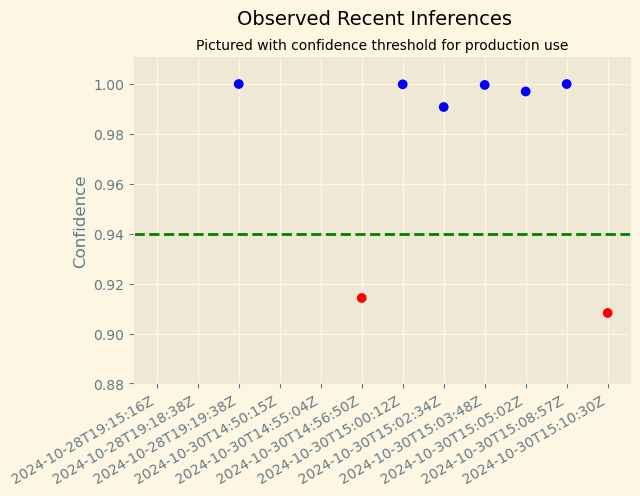

In [147]:
import matplotlib.pyplot as plt

# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data
plt.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
plt.axhline(y=0.94, color='g', linestyle='--')
plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

# Scones Unlimited Data Ingestion Workload Invocation

### Re-deploy Registered Model

In [7]:
import boto3

# Initialize the SageMaker client
sm_client = boto3.client('sagemaker')

# Define the model package group name
model_package_group_name = "Model-Group-1729986112524"

# List model packages in the specified group
model_packages = sm_client.list_model_packages(
    ModelPackageGroupName=model_package_group_name,
    SortBy='CreationTime',
    SortOrder='Descending'
)

# Get the ARN of the latest model package
model_package_arn = model_packages['ModelPackageSummaryList'][0]['ModelPackageArn']

print(f"Using model package ARN: {model_package_arn}")

Using model package ARN: arn:aws:sagemaker:us-east-1:002427974286:model-package/Model-Group-1729986112524/3


In [8]:
import sagemaker
from sagemaker import ModelPackage
from sagemaker.model_monitor import DataCaptureConfig

# Initialize a SageMaker session
sagemaker_session = sagemaker.Session()

# Initialize the SageMaker client
sagemaker_client = boto3.client('sagemaker')

bucket= "udacity-landingzone"
print("Default Bucket: {}".format(bucket))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

# Create a ModelPackage object using the ARN
model_package = ModelPackage(
    role=role,
    model_package_arn=model_package_arn,
    sagemaker_session=sagemaker_session
)

# Create data capture configuration
data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/projects/ml-workflow/data_capture"
)

# Create endpoint
endpoint_name = "scones-unlimited-prod-ep"
try:
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
except: pass
deployment = model_package.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    data_capture_config=data_capture_config,
    endpoint_name=endpoint_name
    )

print(f"Endpoint name: {endpoint_name}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Default Bucket: udacity-landingzone
RoleArn: arn:aws:iam::002427974286:role/service-role/AmazonSageMaker-ExecutionRole-20240924T190146
-------------!Endpoint name: scones-unlimited-prod-ep


In [9]:
# Testing re-deployment of model for final part of project
import sagemaker
from sagemaker.serializers import IdentitySerializer
import base64

endpoint_name = "scones-unlimited-prod-ep"
predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_000513.png", "rb") as f:
    payload = f.read()
    
inference = predictor.predict(payload)

print(f"Inference: {inference}")

Inference: b'[0.8031924962997437, 0.02847396582365036, 0.16176168620586395, 0.003500311868265271, 0.0030715561006218195]'


## S3 Ingestion Class Helper

In [10]:
import boto3
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from uuid import uuid4
import numpy as np

class S3Ingestion:

    DEFAULT_BUCKET = "udacity-landingzone"
    SINGLE_IMAGE_KEY = "projects/ml-workflow/landingzone/ingested_data/"
    BATCH_IMAGE_KEY = "projects/ml-workflow/landingzone/ingested_data/batch-invocation/"

    def __init__(self, bucket_name: str = None) -> None:
        """
        Initialize the S3Ingestion class.

        Parameters:
        bucket_name (str): The name of the bucket to use. Leave as None to use the default bucket.
        """

        if not bucket_name:
            print(f"-> Using bucket: {self.DEFAULT_BUCKET}")

        self.bucket_name = bucket_name or self.DEFAULT_BUCKET
        self.s3 = boto3.client('s3')
        

    def _save_images(self):
        """
        Internal process to save the images prior to ingestion.

        Returns:
        int: The status code of the ingestion process.
        """

        def get_rbg(row):
            test_image = np.dstack((
                row[0:1024].reshape(32,32),
                row[1024:2048].reshape(32,32),
                row[2048:].reshape(32,32)
            ))
            return test_image

        print("-> Saving images to the ./raw_images")
        if not os.path.exists("./raw_images"):
            os.mkdir("./raw_images")
            
        for index, row in self._df_train.iterrows():
            image_path = f"./raw_images/{row['filename']}"
            if os.path.exists(image_path): continue
            plt.imsave(image_path, get_rbg(self._dataset_train[b'data'][row['row']]))

        for index, row in self._df_test.iterrows():
            image_path = f"./raw_images/{row['filename']}"
            if os.path.exists(image_path): continue
            plt.imsave(image_path, get_rbg(self._dataset_test[b'data'][row['row']]))
        
        # Return any signal data you want for debugging
        return 0


    def structure_data(self, coarse_labels_regex: str) -> int:
        """
        Structure image data with image labels and filter by coarse label.

        Parameters:
        coarse_labels_regex (str): Regular expression to filter the coarse labels.

        Returns:
        pd.DataFrame: A dataframe containing the image data and labels.
        """

        global dataset_meta, dataset_test, dataset_train

        with open("./cifar-100-python/meta", "rb") as f:
            dataset_meta = pickle.load(f, encoding='bytes')

        test_path = "./cifar-100-python/test"
        with open(test_path, "rb") as f:
            dataset_test = pickle.load(f, encoding='bytes')
            self._dataset_test = dataset_test

        train_path = "./cifar-100-python/train"
        with open(train_path, "rb") as f:
            dataset_train = pickle.load(f, encoding='bytes')
            self._dataset_train = dataset_train

        # Extracting labels
        fine_label_df = pd.DataFrame([label.decode('utf-8') for label in dataset_meta[b'fine_label_names']], columns=["fine_label"])
        coarse_label_df = pd.DataFrame([label.decode('utf-8') for label in dataset_meta[b'coarse_label_names']], columns=["coarse_label"])

        #Construct the dataframe
        df_train = pd.DataFrame({
            "filename": dataset_train[b'filenames'],
            "labels": dataset_train[b'fine_labels'],
            "coarse_labels": dataset_train[b'coarse_labels'],
            "row": range(len(dataset_train[b'filenames']))
        })

        # Join the labels
        df_train = df_train.merge(fine_label_df, left_on="labels", right_index=True)
        df_train = df_train.merge(coarse_label_df, left_on="coarse_labels", right_index=True)

        # Decode df_train.filenames so they are regular strings
        df_train["filename"] = df_train["filename"].apply(
            lambda x: x.decode("utf-8")
        )
        df_train["file_path"] = df_train["filename"].apply(lambda x: os.path.join("./raw_images", x))

        df_test = pd.DataFrame({
            "filename": dataset_test[b'filenames'],
            "labels": dataset_test[b'fine_labels'],
            "coarse_labels": dataset_test[b'coarse_labels'],
            "row": range(len(dataset_test[b'filenames']))
        })

        # Join the labels
        df_test = df_test.merge(fine_label_df, left_on="labels", right_index=True)
        df_test = df_test.merge(coarse_label_df, left_on="coarse_labels", right_index=True)

        # Decode df_test.filenames so they are regular strings
        df_test["filename"] = df_test["filename"].apply(
            lambda x: x.decode("utf-8")
        )
        df_test["file_path"] = df_test["filename"].apply(lambda x: os.path.join("./raw_images", x))

        # Join all the data
        self._df_train = df_train
        self._df_test = df_test
        all_images_df = pd.concat([df_train, df_test])

        # Filter the data
        self.filtered_images_df = all_images_df[all_images_df['coarse_label'].str.contains(coarse_labels_regex)]

        # Display the data filtered for visual validation
        print("-> Including the following fine labels:")
        display(self.filtered_images_df.value_counts("fine_label"))

        print("-> Example data:")
        display(self.filtered_images_df.head())

        self._save_images()

        return 0


    def ingest_single_random_image_to_s3(self) -> int:
        """
        Ingest data to s3 to start a single process.

        Returns:
        int: The status code of the ingestion process.
        """

        # Choosing a random image from the filtered data
        filename, image_path = ingest.filtered_images_df.sample(1)[['filename', 'file_path']].values[0]

        # Uploading data to s3 without name to mimick an unknwon frame capture
        destination_path = os.path.join(self.SINGLE_IMAGE_KEY, str(uuid4()) + '.png')
        print(f"-> Ingesting image: {image_path} to s3 bucket: s3://{self.bucket_name}/{destination_path}")
        self.s3.upload_file(image_path, self.bucket_name, destination_path)

        return 0


    def ingest_batch_images_to_s3(self, size: int=3) -> int:
        """
        Ingest batch data into s3 to start a parallel process.

        Parameters:
        size (int): The number of images to ingest. Default is 3.

        Returns:
        int: The status code of the ingestion process.
        """
        
        # Extrating the sample images
        batch_images = self.filtered_images_df.sample(5)["file_path"].to_list()

        print(f"-> Ingesting batch images to s3 bucket: s3://{self.bucket_name}/{self.BATCH_IMAGE_KEY}")
        for image_path in batch_images:
            print(f"\t-> Ingesting image: {image_path}")
            # self.s3.upload_file(image_path, self.bucket_name, self.BATCH_IMAGE_KEY)

        return 0

## Model Monitoring Video Footage Snapshot (mockup)

In [11]:
ingest = S3Ingestion()
ingest.structure_data("vehicles_1")

-> Using bucket: udacity-landingzone
-> Including the following fine labels:


fine_label
bicycle         600
bus             600
motorcycle      600
pickup_truck    600
train           600
Name: count, dtype: int64

-> Example data:


,filename,labels,coarse_labels,row,fine_label,coarse_label,file_path
6,car_train_s_000043.png,90,18,6,train,vehicles_1,./raw_images/car_train_s_000043.png
16,bike_s_000682.png,8,18,16,bicycle,vehicles_1,./raw_images/bike_s_000682.png
30,bike_s_000127.png,8,18,30,bicycle,vehicles_1,./raw_images/bike_s_000127.png
47,train_s_001640.png,90,18,47,train,vehicles_1,./raw_images/train_s_001640.png
130,cycle_s_002598.png,8,18,130,bicycle,vehicles_1,./raw_images/cycle_s_002598.png


-> Saving images to the ./raw_images


0

### 1 frame per 5 seconds of footage snapshots

In [37]:
from time import sleep
for i in range(5):
    ingest.ingest_single_random_image_to_s3()
    sleep(5)

-> Ingesting image: ./raw_images/pickup_truck_s_000388.png to s3 bucket: s3://udacity-landingzone/projects/ml-workflow/landingzone/ingested_data/c2802426-8767-46b5-b4a1-26cc7c1f99a2.png
-> Ingesting image: ./raw_images/bike_s_000304.png to s3 bucket: s3://udacity-landingzone/projects/ml-workflow/landingzone/ingested_data/09313d36-ec7a-43f8-9217-bf0ace968b1f.png
-> Ingesting image: ./raw_images/bus_s_000049.png to s3 bucket: s3://udacity-landingzone/projects/ml-workflow/landingzone/ingested_data/179692d2-475f-477c-9fba-e95e69efc1dd.png
-> Ingesting image: ./raw_images/pickup_truck_s_002635.png to s3 bucket: s3://udacity-landingzone/projects/ml-workflow/landingzone/ingested_data/460612be-6424-438a-8f88-43db5acfff0e.png
-> Ingesting image: ./raw_images/train_s_001844.png to s3 bucket: s3://udacity-landingzone/projects/ml-workflow/landingzone/ingested_data/156d07a8-b82a-4ddc-b7f4-adfbb95964f2.png


## Monitoring Visualization


### Monitoring Application 

In [1]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json


class SconesUnlimitedMonitor:

    DEFAULT_THRESHOLD=.94

    def __init__(self, threshold=None):

        # Attributes
        if threshold:
            self.DEFAULT_THRESHOLD = threshold

        # Setting up the data
        self._get_data_capture_date()
        self._get_inference_data()

    def _get_inference_data(self):
        """
        """
    
        s3 = boto3.client("s3")
        
        # List all objects in the category_data folder
        bucket = "udacity-landingzone"
        folder_key = 'projects/ml-workflow/landingzone/categorized_data/'
        response = s3.list_objects_v2(Bucket=bucket, Prefix=folder_key)
        
        contents = response.get("Contents")
        
        new_labels_dict = dict(
            category=[],
            filename=[],
            s3_key=[],
            last_modified=[]
        )
        
        for content in contents:
        
            # Split key to find categories and file names
            s3_key = content.get("Key")
            key_split = s3_key.split("/")
        
            # Filter category_data folder
            if len(key_split) < 6: continue    
        
            # Finding category and filename
            category = key_split[4]
            filename = key_split[-1]
        
            # Getting last modified
            last_modified = content.get("LastModified")
        
            # Creating the dictionary
            new_labels_dict["category"].append(category)
            new_labels_dict["filename"].append(filename)
            new_labels_dict["s3_key"].append(s3_key)
            new_labels_dict["last_modified"].append(last_modified)
    
        df =  pd.DataFrame(new_labels_dict) 
        df["last_modified"] = pd.to_datetime(df["last_modified"].dt.date) 
    
        df = df.groupby(["last_modified", "category"], as_index=False).size()
        df.columns = ["last_modified", "category", "row_count"]
        self.new_labels_df = df
    
    
    def _get_data_capture_date(self):
        """
        """
        
        s3 = boto3.client("s3")
            
        # List all objects in the category_data folder
        bucket = "udacity-landingzone"
        folder_key = 'projects/ml-workflow/data_capture/'
        response = s3.list_objects_v2(Bucket=bucket, Prefix=folder_key)
        
        contents = response.get("Contents")
        
        json_data = []
        if not contents: raise Exception("No data capture found!")
        for content in contents:
            object_key = content.get("Key")
        
            response = s3.get_object(Bucket=bucket, Key=object_key)
        
            # Read and process the JSONL content
            for line in response['Body'].iter_lines():
                if line:  # Check if line is not empty
                    json_data.append(json.loads(line.decode('utf-8')))

        self.json_data = json_data

        def simple_getter(obj):
            inferences = obj["captureData"]["endpointOutput"]["data"]
            timestamp = obj["eventMetadata"]["inferenceTime"]
            return json.loads(inferences), timestamp
    
        # Populate the data for the x and y axis
        x = []
        y = []
        for obj in json_data:
            inference, timestamp = simple_getter(obj)
            
            y.append(max(inference))
            x.append(timestamp)
    
        df = pd.DataFrame(dict(
            timeframe=x,
            inference=y,
            color=['r' if k<.94 else 'b' for k in y ]
        ))
    
        # df["timeframe"] = pd.to_datetime(df["timeframe"])
        df["inference"] = df["inference"].apply(float)
    
        self.model_data_capture_df = df.sort_values("timeframe") 
        
    
    def show_dashboard(self):
    
    
        fig = plt.figure(figsize=(20, 20))
        plt.style.use("Solarize_Light2")
    
        
        #######################
        # TOP-LEFT SCATTER PLOT
        ax1 = fig.add_subplot(2, 2, 1)
        
        # Plot the data   
        df = self.model_data_capture_df
        
        # Separate scatter plots for each color with labels for the legend
        below_threshold = df[df["inference"] < self.DEFAULT_THRESHOLD].sort_values("timeframe")
        above_threshold = df[df["inference"] >= self.DEFAULT_THRESHOLD].sort_values("timeframe")

        # Scatter plot for below and above threshold
        ax1.scatter(below_threshold["timeframe"], below_threshold["inference"], color='r', label="Below Threshold")
        ax1.scatter(above_threshold["timeframe"], above_threshold["inference"], color='b', label="Above Threshold")
        
        # Add threshold line
        ax1.axhline(y=self.DEFAULT_THRESHOLD, color='g', linestyle='--', label="Confidence Threshold")
        ax1.set_ylim(bottom=df["inference"].min() - .01)
        
        # Add labels
        ax1.set_ylabel("Confidence")
        ax1.set_title("Observed Recent Inferences", size=16, pad=30)
        ax1.text(0.5, 1.02, "Scatter plot of inferences over time to monitor trend of inferences", fontsize=10, ha="center", va="bottom", transform=ax1.transAxes)
        ax1.set_xlabel("Model Run Datetime")
        
        # Set x-axis ticks at intervals, including the first and last points
        num_ticks = 4 
        tick_indices = [0] + list(range(len(df) // num_ticks, len(df), len(df) // num_ticks)) + [len(df) - 1]
        
        # Generate tick positions and labels
        xticks_positions = tick_indices 
        xticks_labels = pd.to_datetime(df["timeframe"]).iloc[tick_indices].dt.strftime("%Y-%m-%d %H:%M:%S")  # Format datetime labels
        
        # Apply the ticks and labels
        ax1.set_xticks(xticks_positions)
        ax1.set_xticklabels(xticks_labels, rotation=10, fontsize=10)

        # Add legend
        ax1.legend(loc = 'center left', bbox_to_anchor=(.7, 0.1), fontsize = 12)
            
        ####################
        # TOP-RIGHT BOX PLOT 
        ax2 = fig.add_subplot(2, 2, 2)
        df.plot.box(y="inference", vert=True, patch_artist=True, widths=0.7, ax=ax2)
        ax2.axhline(y=self.DEFAULT_THRESHOLD, color='g', linestyle='--', label="Confidence Threshold")
        
        # Calculate and add the mean line in red
        mean_inference = df["inference"].median()
        ax2.axhline(y=mean_inference, color='r', linestyle='-', label="Mean Inference")

        # Add legend and title
        ax2.legend(loc = 'center left', bbox_to_anchor=(.8, 0.1), fontsize = 12)
        ax2.set_title("Overal Inference Drift Quartiles", size=16, pad=30)
        ax2.text(0.5, 1.02, "Box plot showing inference distribution and tracking the median", fontsize=10, ha="center", va="bottom", transform=ax2.transAxes)

        #######################
        # BOTTOM LONG AREA PLOT
        plt.subplots_adjust(hspace=.25)
        df = self.new_labels_df
        ax3 = fig.add_subplot(2, 1, 2)
        df_pivot = df.pivot_table(index="last_modified", values="row_count", columns="category")
        df_pivot.plot.area(ax=ax3)
    
        # Annotation groups
        text_group_df = df.groupby(["last_modified", "category"], as_index=False).sum()
        text_group_df = text_group_df.sort_values(["last_modified", "category"]).assign(y_pos=lambda x: x.groupby("last_modified")["row_count"].cumsum())
        
        for _, row in text_group_df.iterrows():
            x_pos = row["last_modified"]
            y_pos = row["y_pos"]
            text = row["row_count"]
        
            ax3.text(x_pos, y_pos - .5, text, ha="center", fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
            
        ax3.set_title("Created Snapshots for Relabeling", fontsize = 16, loc = 'center', pad=30)
        ax3.text(0.5, 1.02, 
                 "Area plot showing new snapshots (from camera feed) created and unknown labels to re-label for future training", 
                 fontsize=10, ha="center", va="bottom", transform=ax3.transAxes)
        ax3.set_ylabel("Image Count", fontsize = 22)
        ax3.set_xticks(df_pivot.index)
        ax3.set_xlabel("Frame Snapshot Date", fontsize = 22)
        ax3.legend(loc = 'center left', bbox_to_anchor=(.98, 0.5), fontsize = 12)

        fig.suptitle("Scones Unlimited Vehicle Image Recognition Model Drift", fontsize=22, fontweight='bold', y=.94)

### Monitoring Dashboard

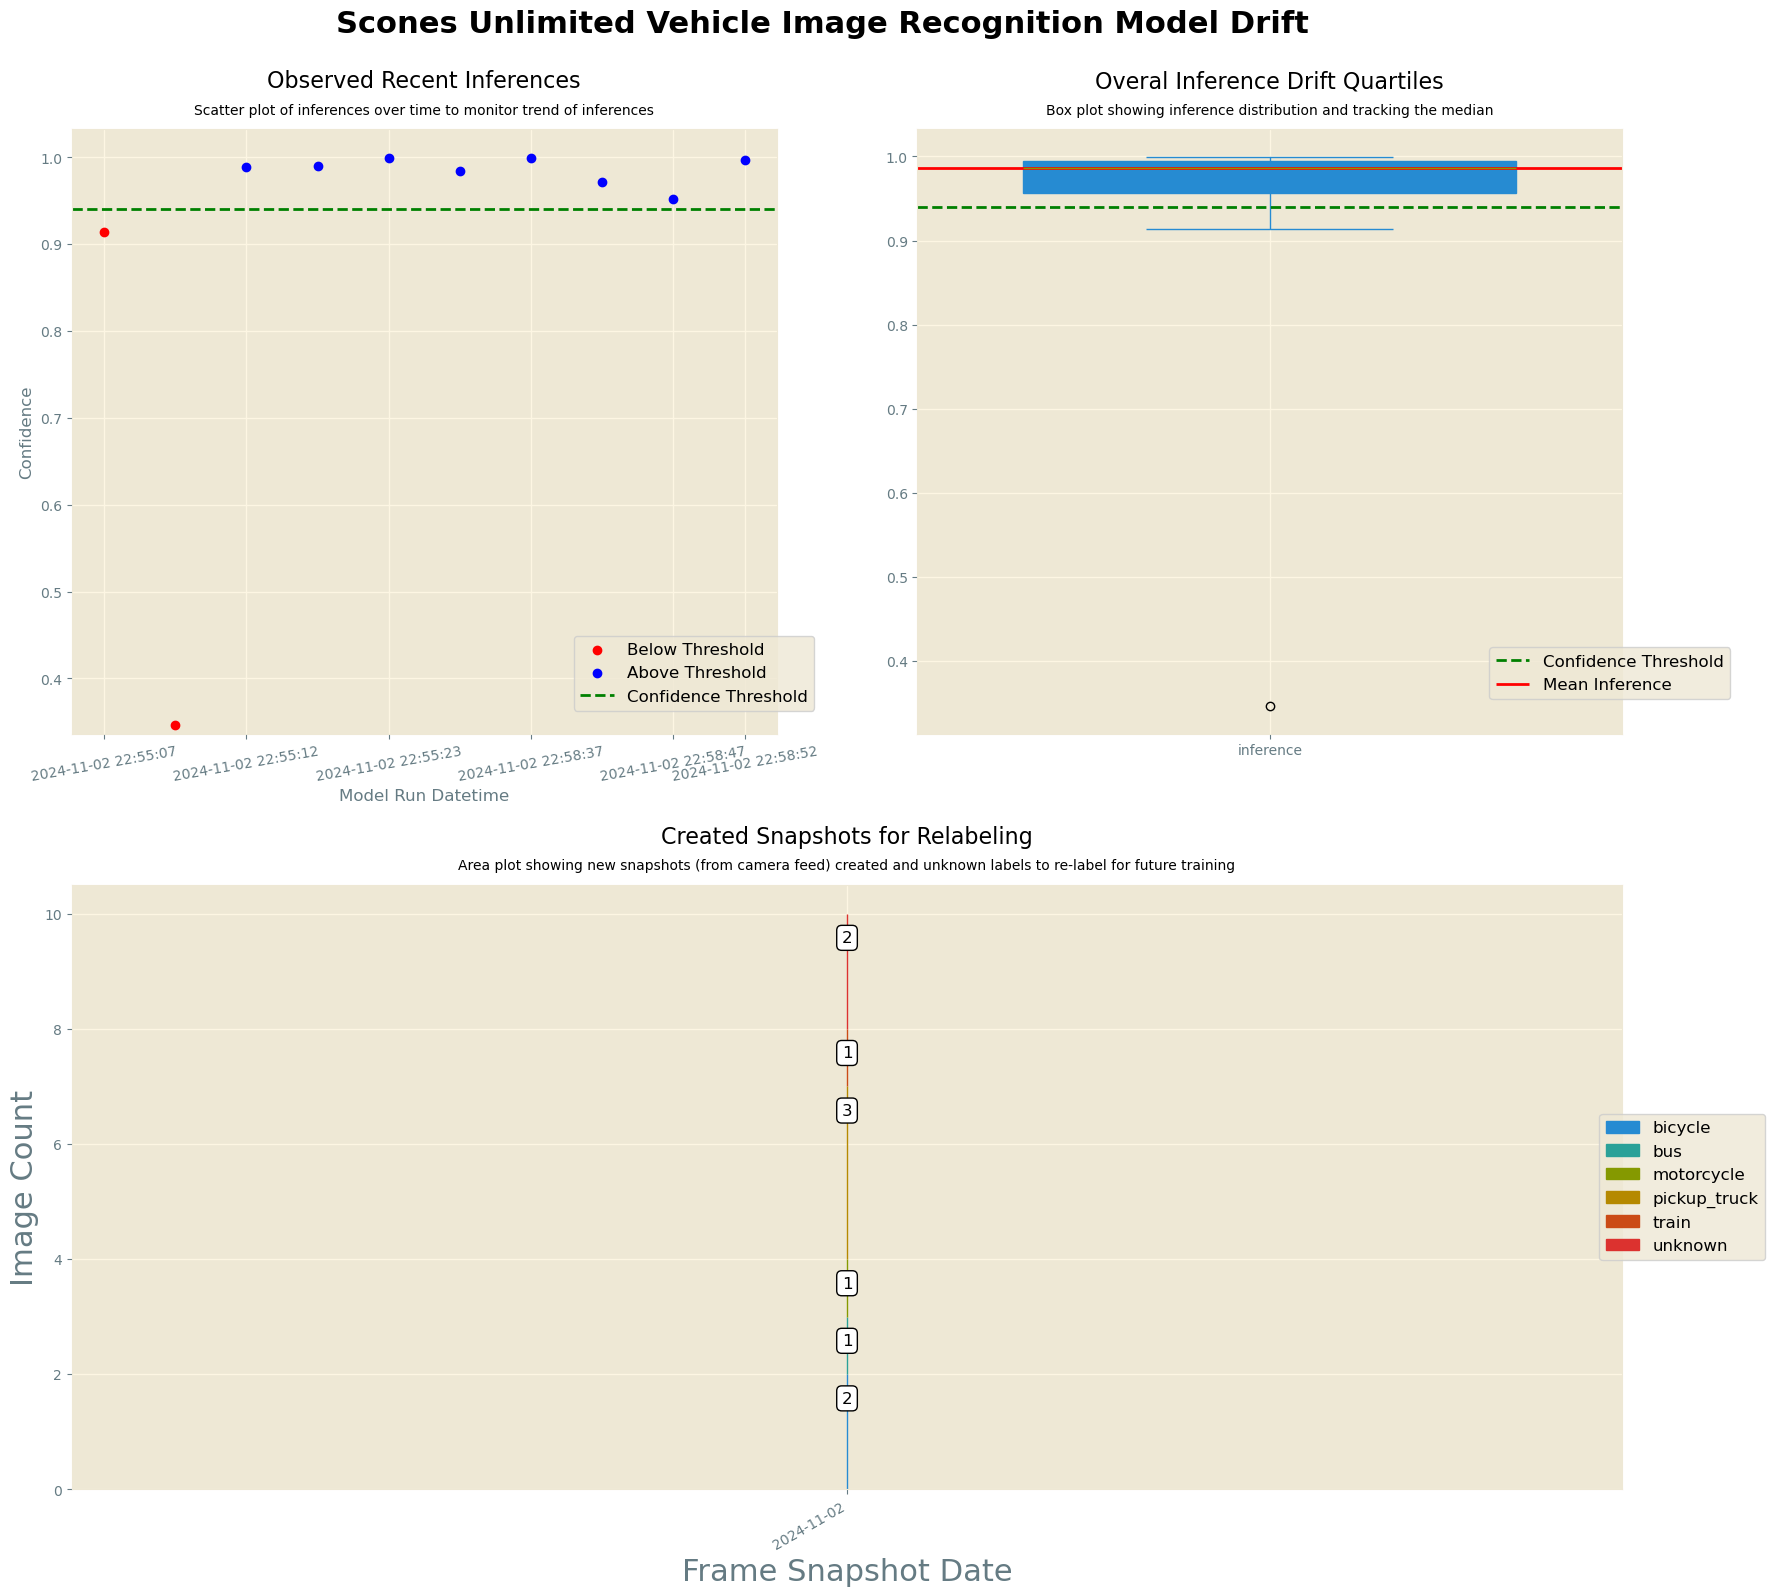

In [2]:
scones = SconesUnlimitedMonitor(
    threshold=.94
)
scones.show_dashboard()

## Congratulations!

You've reached the end of the project. In this project you created an event-drivent ML workflow that can be incorporated into the Scones Unlimited production architecture. You used the SageMaker Estimator API to deploy your SageMaker Model and Endpoint, and you used AWS Lambda and Step Functions to orchestrate your ML workflow. Using SageMaker Model Monitor, you instrumented and observed your Endpoint, and at the end of the project you built a visualization to help stakeholders understand the performance of the Endpoint over time. If you're up for it, you can even go further with these stretch goals:

* Extend your workflow to incorporate more classes: the CIFAR dataset includes other vehicles that Scones Unlimited can identify with this model.
* Modify your event driven workflow: can you rewrite your Lambda functions so that the workflow can process multiple image inputs in parallel? Can the Step Function "fan out" to accomodate this new workflow?
* Consider the test data generator we provided for you. Can we use it to create a "dummy data" generator, to simulate a continuous stream of input data? Or a big paralell load of data?
* What if we want to get notified every time our step function errors out? Can we use the Step Functions visual editor in conjunction with a service like SNS to accomplish this? Try it out!




TODO:
* Copy new lambdas to lambda.py
* Take images of succesful lambda functions 